In [1]:
# %matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

## Funciones generales

In [2]:
#Da el espectro identificando los primeros máximos sin analizar
def Spectrum(datax,datay,intensity,num):
    marker_x = []
    marker_y = []
    index_y = []
    index_x = []
    anotaciones = []

    for i in range(0,len(datax)):
        mark = i

        if mark != 0 and mark != len(datax)-1:
            last = datay[mark - 1]
            next = datay[mark + 1]

            #Hallar máximos de espectro
            if (last < datay[i]) and (next < datay[i]) and (datay[i]>intensity):
                marker_x.append(datax[i])
                marker_y.append(datay[i])

                index_y.append( datay[i-num:i+num] )
                index_x.append( datax[i-num:i+num] )

                anotaciones.append(str(datax[i]))
                
    return marker_x,marker_y,index_x,index_y,anotaciones


#Procesa el archivo txt de datos, inten se refiere a la intensidad mínima para buscar y num a la cantidad de puntos alrededor de la lorentziana
def DataProcess(l,inten,num):
    data = pd.read_csv(l, delimiter=' ')
    pixel = np.array(data['P'])
    intensidad = np.array(data['I'])

    marker_x,marker_y, index_x,index_y,anotaciones = Spectrum(pixel,intensidad,inten,num)
    
    return pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones


#Retira aquellas líneas que no aparecen en el catálogo o no ayudan a la obtención de la lorentziana
def DataCatalogue(pixs,marker_x,marker_y, index_x,index_y,anotaciones):
    mar_x = []
    mar_y = []
    ind_y = []
    ind_x = []
    anot = []
   

    for i in range(0,len(marker_x)):
        if marker_x[i] not in pixs:
            mar_x.append(marker_x[i])
            mar_y.append(marker_y[i])
            ind_x.append(index_x[i])
            ind_y.append(index_y[i])
            anot.append(anotaciones[i])

    return mar_x,mar_y, ind_x,ind_y,anot


#Función Lorentziana
def Lorentzian(x,h,x0,W):
    return h*W**2/((x-x0)**2+W**2)


#Realiza el ajuste Lorentziano sobre el espectro catalogado
def AjusteLorentz(i,index_x, index_y):
    x = index_x[i]
    y = index_y[i] 
    x_1 = np.linspace(x[0],x[-1],500 )

    popt, _ = curve_fit(Lorentzian,x,y) 
    h = popt[0]
    x0 = popt[1]
    w = popt[2]

    fit_y= Lorentzian(x_1,h,x0,w)

    return x0,h,fit_y,x_1, x, y


#Devuelve el DataFrame con los píxeles calculados
def MakeDataFrame(rango,catalog_long,index_x, index_y):

    Datafit = pd.DataFrame()
    lineasfit = []
    alturafit = []

    for i in range(0,rango):
        linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x, index_y)
        lineasfit.append(linea)
        alturafit.append(altura)
    

    Datafit['Pixel'] = lineasfit
    Datafit['Intensidad'] = alturafit
    Datafit['Catalogo longitud'] = catalog_long

    return Datafit

#Obtener la regresion lineal
def LinearFit(datax,datay,n):
    param = np.polyfit(datax,datay, n)
    xm = np.linspace(min(datax),max(datax),len(datax))
    ym = np.polyval(param, xm)
    xres = datax
    ye = np.polyval(param, datax)
    res = ye - datay

    return ym,xm,res,xres,param

#Obtener la calibración de las lineas sospechosas
def LineasSus(pixs,param):
    Data = pd.DataFrame()
    Data['Pixel'] = pixs
    Orden1 = []
    Orden2 = []
    Orden3 = []
    for i in pixs:
        Orden1.append(np.polyval(param,i)*2)
        Orden2.append(np.polyval(param,i)) 
        Orden3.append(np.polyval(param,i)*(2/3)) 
    
    Data['Calibracion orden 1'] = Orden1
    Data['Calibracion orden 2'] = Orden2
    Data['Calibracion orden 3'] = Orden3

    return Data

#Convertir DataFrame a tabla de Latex
# print(DataFit_1.to_latex(index=False))

# Linea para guardar la imagen de un fig
#fig2.savefig('th 6200 orden 2 espectro tratado.jpg')

### Para intensidades grandes >525

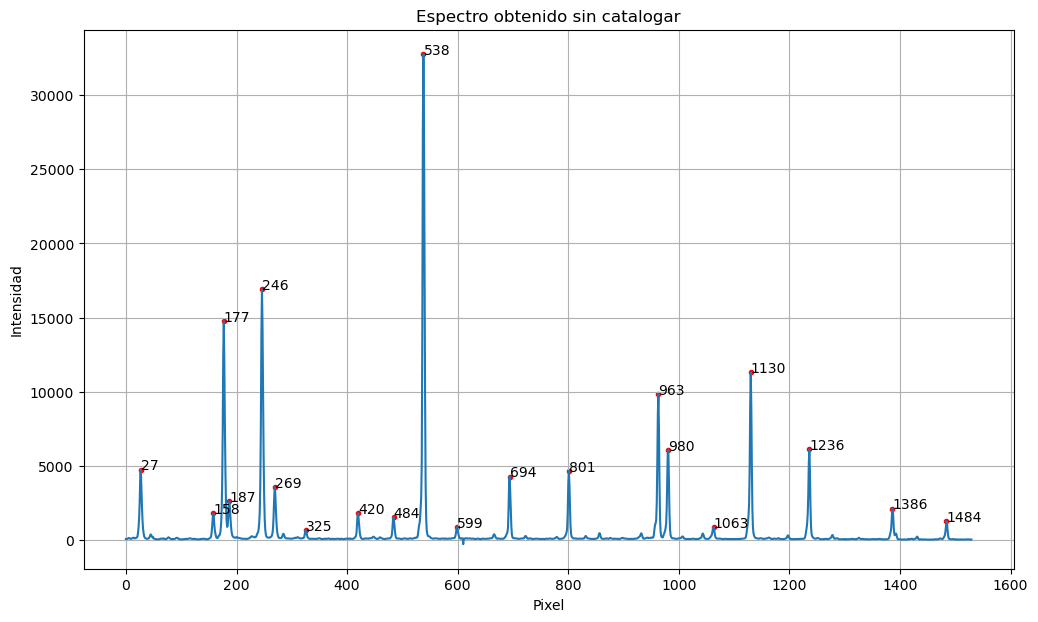

In [3]:
pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6200\th 6200 orden 2 spec.txt", 525, 7)

#Grafica para ver el espectro completo y cuadrar hasta qué intensidad mirar
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x,marker_y,marker='.',color = 'red')
ax1.set_title('Espectro obtenido sin catalogar')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))

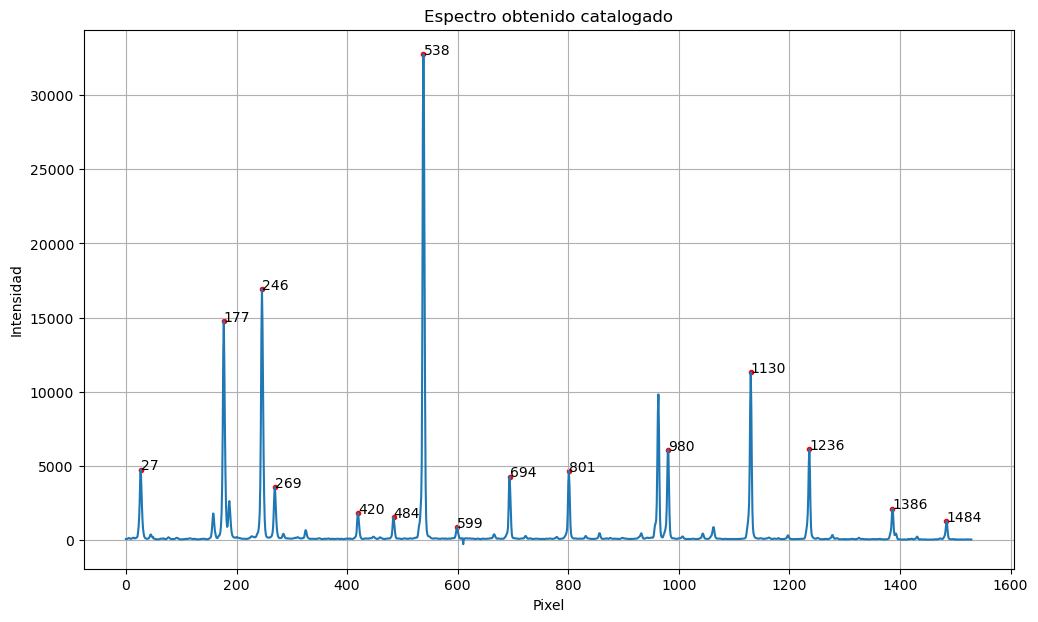

In [4]:
#Lista de pixeles que se descartan al no estar en el espectro
Pixnon_1 = [158,187,325,963,1063]

#Se obtiene el espectro limpio sin los píxeles diferentes
marker_xl,marker_yl, index_xl,index_yl,anotacionesl = DataCatalogue(Pixnon_1,marker_x,marker_y, index_x,index_y,anotaciones)
    
#Grafica del espectro sin las líneas que no pertenecen  
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
ax2.plot(pixel,intensidad)
ax2.scatter(marker_xl,marker_yl,marker='.',color = 'red')
ax2.set_title('Espectro obtenido catalogado')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensidad')
ax2.grid()
for i, label in enumerate(anotacionesl):
    plt.annotate(label, (marker_xl[i] + 0.1, marker_yl[i]))


In [5]:
#Longitudes de onda observadas en el catalogo de los píxeles que sí se lograron ver, ingreso manual
catalog_long_1 = [ 6164.48, 6169.82, 6172.28, 6173.10, 6178.43, 6180.71, 6182.62, 6184.78, 6188.13, 6191.91, 6198.22, 6203.49, 6207.22, 6212.51, 6215.95 ]

#Lista de líneas sospechosas que sí están en el espectro pero no catalogadas
Pixesp_1 = []

#Lista de líneas completamente sospechosas 
Pixsus_1 = [158,187,325,963,1063]

#Unir dataframes de líneas en el catalogo
DataFit_1 = MakeDataFrame(len(marker_xl),catalog_long_1,index_xl, index_yl)
DataFit_1

,Pixel,Intensidad,Catalogo longitud
0,26.739237,5001.843023,6164.48
1,177.003305,15353.196491,6169.82
2,246.166012,17790.356097,6172.28
3,269.326072,3712.917762,6173.10
4,419.733042,1940.660105,6178.43
5,483.937532,1615.436804,6180.71
6,538.155619,35320.053900,6182.62
7,598.895878,875.488513,6184.78
8,693.850607,4563.389237,6188.13
9,801.067003,4910.602039,6191.91


### Para líneas con intensidades pequeñas < 525

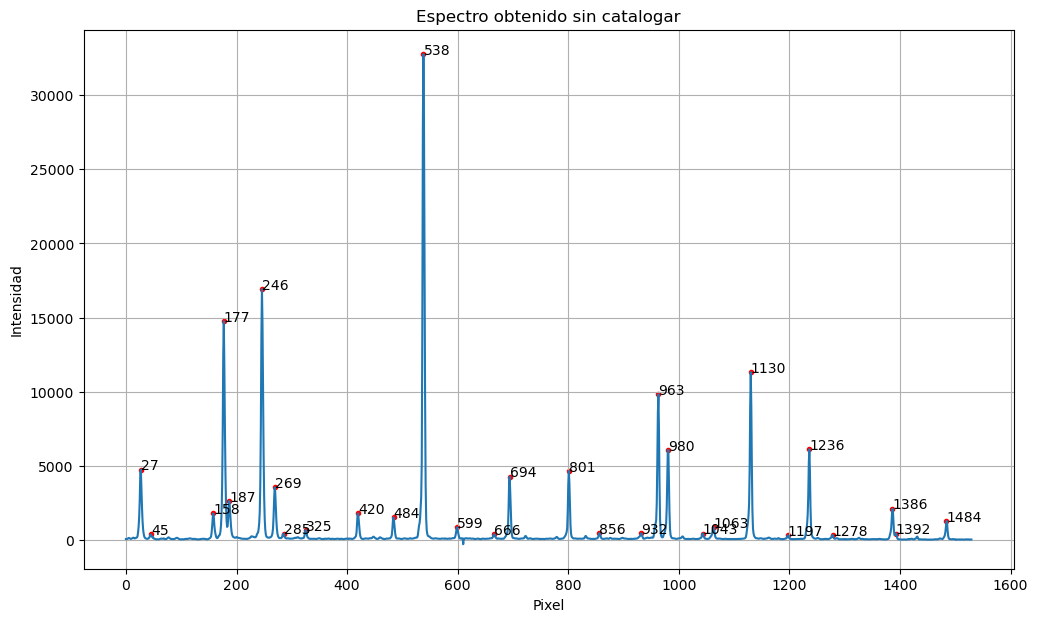

In [6]:
pixel,intensidad,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6200\th 6200 orden 2 spec.txt",275,18)

#Grafica para ver el espectro completo y cuadrar hasta qué intensidad mirar
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x_,marker_y_,marker='.',color = 'red')
ax1.set_title('Espectro obtenido sin catalogar')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones_):
    plt.annotate(label, (marker_x_[i] + 0.1, marker_y_[i]))

In [7]:
# #Longitudes de onda observadas en el catalogo de los píxeles que sí se lograron ver, ingreso manual
# catalog_long_2 = [  ]

# #Lista de líneas sospechosas que sí están en el espectro pero no catalogadas
Pixesp_2 = []

#Lista de líneas completamente sospechosas 
Pixsus_2 = [45,666,1043]

# #Unir dataframes de líneas en el catalogo
# DataFit_2 = MakeDataFrame(len(marker_xl),catalog_long_2,index_xl, index_yl)
# DataFit_2

#### Primera linea 856

In [10]:
#NO CONFUNDIR, son lineas ya analizadas, es para poder hacer un análisis más detallado a las lineas que por la intensidad toca separarlas del análisis general
pixsus = [1197,1278,45,666,1043,27,158,177,187,246,269,285,325,420,484,538,599,694,801,932,963,980,1063,1130,1236,1386,1392,1484] 

pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6200\th 6200 orden 2 spec.txt",275,10)
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

catalog_long_2 = [6193.86]
DataFit_21 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

DataFit_21

,Pixel,Intensidad,Catalogo longitud
0,856.430514,457.661045,6193.86


#### Primera linea 1197

In [11]:
pixsus = [856,1278,45,666,1043,27,158,177,187,246,269,285,325,420,484,538,599,694,801,932,963,980,1063,1130,1236,1386,1392,1484] #lineas ya analizadas

pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6200\th 6200 orden 2 spec.txt",275,18)
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

catalog_long_2 = [ 6205.86]
DataFit_22 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

DataFit_22

,Pixel,Intensidad,Catalogo longitud
0,1197.210867,265.775686,6205.86


#### Primera linea 1278

In [12]:
pixsus = [1197,856,45,666,1043,27,158,177,187,246,269,285,325,420,484,538,599,694,801,932,963,980,1063,1130,1236,1386,1392,1484] #lineas ya analizadas

pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6200\th 6200 orden 2 spec.txt",275,18)
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)


def MakeDataFrame(rango,catalog_long,index_x_,index_y_):

    Datafit = pd.DataFrame()
    lineasfit = []
    alturafit = []

    for i in range(0,rango):
        linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x_,index_y_)
        lineasfit.append(linea)
        alturafit.append(altura)
    

    Datafit['Pixel'] = lineasfit
    Datafit['Intensidad'] = alturafit
    Datafit['Catalogo longitud'] = catalog_long

    return Datafit, fity, fitx, x, y

catalog_long_2 = [6208.69]
DataFit_2, fity, fitx, x, y = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

# fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(x,y)

### Unir todo en un dataframe

In [13]:
DataFit = pd.concat([DataFit_1,DataFit_21,DataFit_22], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True)

DataFit
#print(DataFit.to_latex(index=False))

,Pixel,Intensidad,Catalogo longitud
0,26.739237,5001.843023,6164.48
1,177.003305,15353.196491,6169.82
2,246.166012,17790.356097,6172.28
3,269.326072,3712.917762,6173.10
4,419.733042,1940.660105,6178.43
5,483.937532,1615.436804,6180.71
6,538.155619,35320.053900,6182.62
7,598.895878,875.488513,6184.78
8,693.850607,4563.389237,6188.13
9,801.067003,4910.602039,6191.91


### Gráfica del espectro con las líneas encontradas 

In [ ]:
# #Solo utilizar al final cuando ya se esté segura del análisis
# Pixnon = []
# markerx,markery, indexx,indexy,anotaciones = DataCatalogue(Pixnon ,marker_x,marker_y, index_x,index_y,anotaciones)

# #Grafica con aquellas encontradas
# fig, ax = plt.subplots(1,1, figsize=(12,7))
# ax.plot(pixel,intensidad, color='purple')
# ax.scatter(markerx,markery,marker='.',color = 'orange')
# ax.set_title('Espectro obtenido luego del análisis')
# ax.set_xlabel('Pixel (pix)')
# ax.set_ylabel('Intensidad')
# ax.grid()
# for i, label in enumerate(anotaciones):
#     plt.annotate(label, (markerx[i] + 0.1, markery[i]))

# #fig.savefig('th 6200 orden 2 espectro tratado.jpg')

### Regresión lineal de todos los puntos

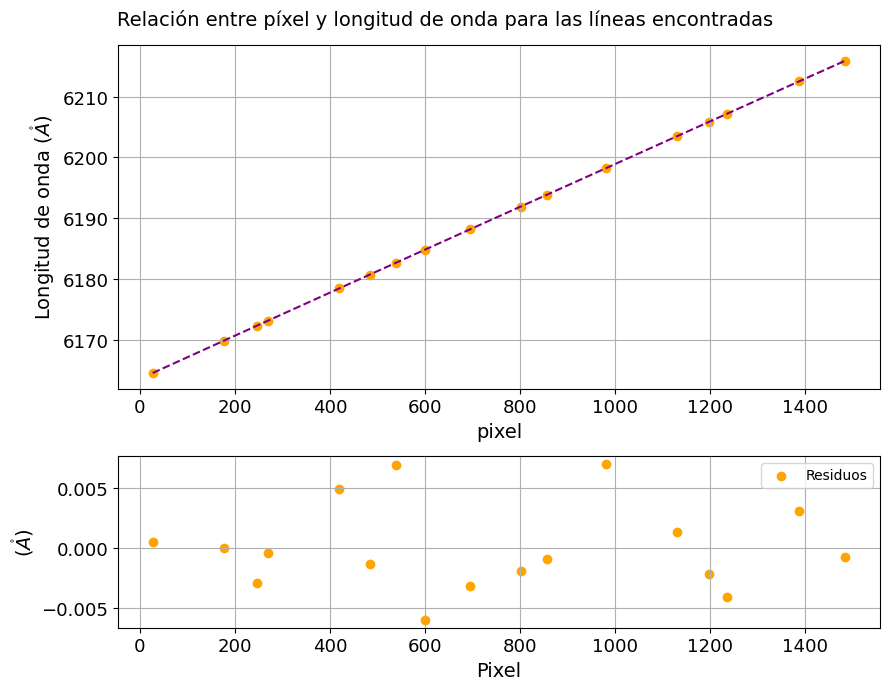

In [16]:
ym,_x,res,xres,param = LinearFit(DataFit['Pixel'],DataFit['Catalogo longitud'], 5) 

#Gráfico con residuos
fig3, axis3 = plt.subplots(2,1, figsize = (9, 7), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis3[0]
ax2 = axis3[1]

fig3.suptitle(r'Relación entre píxel y longitud de onda para las líneas encontradas',fontsize=14)

ax1.scatter(DataFit['Pixel'],DataFit['Catalogo longitud'], color='orange')
ax1.plot(_x,ym,'--',color='purple')
ax1.set_ylabel(r"Longitud de onda $(\mathring{A})$",fontsize=14)
ax1.set_xlabel(r'pixel',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.scatter(xres,res,label = 'Residuos',color='orange')
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)
ax2.legend()
ax2.set_xlabel(r'Pixel',fontsize=14)
ax2.set_ylabel(r'$(\mathring{A})$',fontsize=14)

fig3.tight_layout()
#fig3.savefig('th 6200 regresion lineal.jpg')

### Análisis líneas sospechosas

In [20]:
LineasSos_1 = LineasSus(Pixsus_1,param)
LineasSos_1['Catalogo longitud'] = [4112.754,None , 4116.713, 4131.723, 4134.0678]
LineasSos_1['Elemento'] = [ 'Th I', 'Mezcla', 'Th II', 'Ar II', 'Th I']

LineasSos_2 = LineasSus(Pixsus_2,param)
LineasSos_2['Catalogo longitud'] = [4110.0743, 4124.778, 12400.8154]
LineasSos_2['Elemento'] = [ 'Th II', 'Th I', 'Th I']

LineasSos = pd.concat([LineasSos_1,LineasSos_2], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True).drop([2],axis=0).reset_index(drop=True)
LineasSos['Longitud Calculada'] = [4110.0846, 4112.7654, 4116.7182, 4124.7612, 4131.7429, 12400.8626, 4134.0902]

LineasSos = LineasSos.drop(['Calibracion orden 1','Calibracion orden 2', 'Calibracion orden 3'],axis=1)
LineasSos
# print(LineasSos.to_latex(index=False))

,Pixel,Catalogo longitud,Elemento,Longitud Calculada
0,45,4110.0743,Th II,4110.0846
1,158,4112.7540,Th I,4112.7654
2,325,4116.7130,Th II,4116.7182
3,666,4124.7780,Th I,4124.7612
4,963,4131.7230,Ar II,4131.7429
5,1043,12400.8154,Th I,12400.8626
6,1063,4134.0678,Th I,4134.0902


### Revisar residuos de lineas sospechosas

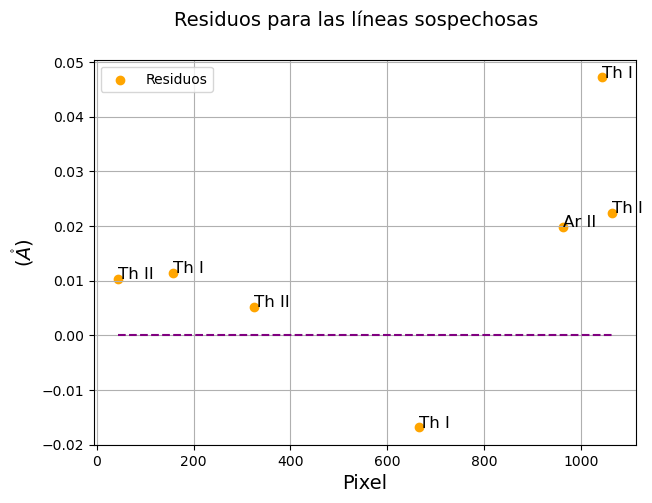

In [18]:
#Calcular residuos de las líneas sospechosas
nist = LineasSos['Catalogo longitud']
calc = LineasSos['Longitud Calculada']
residuos = calc - nist

pixel = LineasSos['Pixel']

#Etiquetas de elementos
label = [each for each in LineasSos['Elemento']]

#Gráfico con residuos
figr, axr = plt.subplots(1,1, figsize=(7,5))

figr.suptitle(r'Residuos para las líneas sospechosas',fontsize=14)

axr.scatter(pixel,residuos,label = 'Residuos',color='orange')
axr.plot(pixel,np.linspace(0,0,len(residuos)),'--',color='purple')
axr.grid()
axr.legend()
axr.set_xlabel(r'Pixel',fontsize=14)
axr.set_ylabel(r'$(\mathring{A})$',fontsize=14)

for j in range (0, len(label)):
    plt.annotate(label[j], (pixel[j], residuos[j]),fontsize=12)

#figr.savefig('Residuos th 6200.jpg')